## Сегментация изображений

In [1]:
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
# ! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
# ! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

### Модуль данных

In [3]:
class YeastSemanticSegmDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image_path = self.items[index]
        image = torch.load(image_path, weights_only=True).unsqueeze(0)  # (W, H) -> (1, W, H)
        # 0 класс - фон, поэтому прибавляем 1 к меткам классов
        labels = torch.load(self.subset_dir / "classes" / image_path.name, weights_only=True) + 1
        masks = torch.load(self.subset_dir / "instances" / image_path.name, weights_only=True)

        # формируем маску: тензор размера W x H, где для каждого пиксела указан класс
        masks = ((masks * labels.view(-1, 1, 1)).sum(dim=0)).long()
        return image, masks

    def __len__(self) -> int:
        return len(self.items)

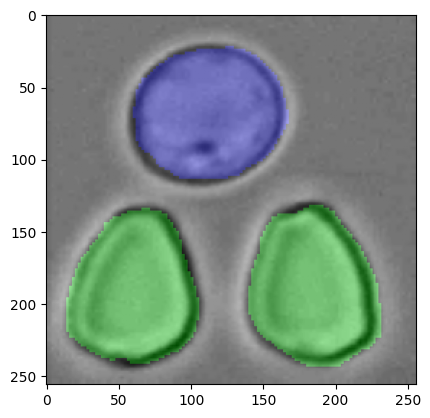

In [4]:
train_dataset = YeastSemanticSegmDataset(Path("yeast_cell_in_microstructures_dataset/train"))

x, y = train_dataset[0]
y = torch.nn.functional.one_hot(y, 3).permute(2, 0, 1).float()
y[0] = 0.0

fig, ax = plt.subplots(1, 1)
ax.imshow(x[0], cmap="gray")
ax.imshow(transforms.ToPILImage()(y), alpha=0.3)

#### `DataModule`

In [5]:
from pathlib import Path

import lightning as L
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from torch.utils.data import DataLoader

class DataModule(L.LightningDataModule):
    def __init__(
        self,
        datadir: Path,
        batch_size: int,
        train_subdir: str = "train",
        val_subdir: str = "val",
        test_subdir: str = "test",
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        datadir = Path(datadir)
        self.train_dir = datadir / train_subdir
        self.val_dir = datadir / val_subdir
        self.test_dir = datadir / test_subdir

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = YeastSemanticSegmDataset(self.val_dir)
        if stage == "fit":
            self.train_dataset = YeastSemanticSegmDataset(self.train_dir)
        elif stage == "test":
            self.test_dataset = YeastSemanticSegmDataset(self.test_dir)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

In [6]:
torch.manual_seed(42)
datamodule = DataModule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    batch_size=8,
)
datamodule.setup("fit")
images, masks = next(iter(datamodule.train_dataloader()))
print(images.shape)
print(masks.shape)

torch.Size([8, 1, 256, 256])
torch.Size([8, 256, 256])


### Модель для семантической сегментации

Возьмём реализацию Unet из https://github.com/milesial/Pytorch-UNet

<!-- [](https://camo.githubusercontent.com/41ded1456b9dbe13b8d73d8da539dac95cb8aa721ebe5fb798af732ca9f04c92/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67?raw=true) -->

<!-- [network architecture](https://i.imgur.com/jeDVpqF.png) -->

<img src="https://i.imgur.com/jeDVpqF.png" style="background:white" width="600"/>

#### Строительные блоки UNet

Основной материал - блок из двух свёрток и нормализаций

In [7]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.double_conv(x)

In [8]:
x_in = torch.randn(4, 3, 64, 64)
x_out = DoubleConv(3, 16).forward(x_in)
print(f"{x_in.shape} -> {x_out.shape}")

torch.Size([4, 3, 64, 64]) -> torch.Size([4, 16, 64, 64])


Далее блок для Downsampling - просто комбинация наших свёрток с MaxPool. Тоже знакомый мотив для быстрого уменьшения размерности.

In [9]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.maxpool_conv(x)

In [10]:
x_in = torch.randn(4, 3, 64, 64)
x_out = Down(3, 16).forward(x_in)
print(f"{x_in.shape} -> {x_out.shape}")

torch.Size([4, 3, 64, 64]) -> torch.Size([4, 16, 32, 32])


Также понадобится способ создать последовательность блоков `Down`:

In [20]:
def create_downscaler(channel_sizes: list[int], bilinear: bool = False) -> nn.ModuleList:
    """
    Создаём список модулей на основе размеров каналов.
    если используется билинейная интерполяция вместо обратной свёртки,
    то размер последнего (самого большого) канала делаем вдвое меньше

    Args:
        channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
        bilinear (bool, optional): если True, в модели используется билинейная интерполяция
            для выравнивания размеров активаций.
    """
    modules = []
    for i in range(len(channel_sizes) - 1):
        in_channels = channel_sizes[i]
        out_channels = channel_sizes[i + 1]
        is_last_module = i == len(channel_sizes) - 2
        # Определяем факторы масштабирования для каждого слоя
        dfactor = 2 if bilinear and is_last_module else 1
        modules.append(Down(in_channels, out_channels // dfactor))

    return nn.ModuleList(modules)

In [ ]:
x_in = torch.randn(4, 16, 32, 32)
downscaler = create_downscaler(channel_sizes=[16, 32, 64, 128], bilinear=False)
x_out = x_in
for conv in downscaler:
    x_out = conv(x_out)
print(f"{x_in.shape} -> {x_out.shape}")

torch.Size([4, 16, 32, 32]) -> torch.Size([4, 128, 4, 4])


А теперь что-то новое: нам нужно из активаций малого пространственного разрешения снова восстанавливать исходное разрешение. Делать мы это также будем в несколько этапов, но теперь у нас есть несколько вариантов.

Простой - использовать интерполяцию при увеличении размерности, например билинейную.

Посложнее - вставить обратные свёртки и сделать обучаемый upsampling

<img src="../assets/images/transposeconv.png" style="background:white" width="600"/>

In [11]:
from torch import nn

x = torch.tensor([[0, 1], [2, 3]], dtype=float).view(1, 2, 2)
kernel = torch.tensor([[4, 1], [2, 3]], dtype=float).view(1, 1, 2, 2)
deconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
deconv.weight.data = kernel
deconv(x)

tensor([[[ 0.,  4.,  1.],
         [ 8., 16.,  6.],
         [ 4., 12.,  9.]]], dtype=torch.float64, grad_fn=<SqueezeBackward1>)

В итоге блок выглядит так:

In [12]:
class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bilinear: bool = True) -> None:
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_prev: Tensor, x_skip: Tensor) -> Tensor:
        x_prev = self.up(x_prev)
        x = torch.cat([x_skip, x_prev], dim=1)
        return self.conv(x)

In [17]:
x_in = torch.randn(4, 64, 4, 4)
x_skip = torch.randn(4, 32, 8, 8)
x_out = Up(64, 32, bilinear=False).forward(x_in, x_skip)
print(f"{x_in.shape} -> {x_out.shape}")

torch.Size([4, 64, 4, 4]) -> torch.Size([4, 32, 8, 8])


Функция для создания последовательности блоков `Up`:

In [44]:
def create_upscaler(channel_sizes: list[int], bilinear: bool = False) -> nn.ModuleList:
    """
    Создаём список модулей на основе размеров каналов.
    Если используется билинейная интерполяция вместо обратной свёртки,
    то размер первого (самого большого) канала делаем вдвое меньше

    Args:
        channel_sizes (list[int]): список размеров каналов, напр. [64, 32, 16]
        bilinear (bool, optional): если True, в модели используется билинейная интерполяция
            для выравнивания размеров активаций.
    """
    modules = []
    for i in range(len(channel_sizes) - 1):
        in_channels = channel_sizes[i]
        out_channels = channel_sizes[i + 1]
        is_last_module = i == len(channel_sizes) - 2
        # Определяем факторы масштабирования для каждого слоя
        dfactor = 2 if bilinear and not is_last_module else 1
        modules.append(Up(in_channels, out_channels // dfactor, bilinear=bilinear))

    return nn.ModuleList(modules)

In [48]:
x_in = torch.randn(4, 16, 32, 32)
bilinear = False
downscaler = create_downscaler(channel_sizes=[16, 32, 64, 128], bilinear=bilinear)
upscaler = create_upscaler(channel_sizes=[128, 64, 32, 16], bilinear=bilinear)

# Понижаем разрешение
x_mid = x_in
xs = []
for conv in downscaler:
    xs.append(x_mid)
    x_mid = conv(x_mid)

# Повышаем обратно
xs.reverse()
x_out = x_mid
for conv, x_prev in zip(upscaler, xs):
    x_out = conv(x_out, x_prev)


print(f"{x_in.shape} -> {x_mid.shape} -> {x_out.shape}")

torch.Size([4, 16, 32, 32]) -> torch.Size([4, 128, 4, 4]) -> torch.Size([4, 16, 32, 32])


#### Архитектура модели

In [ ]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = create_downscaler(channel_sizes, bilinear)
        self.upscaler = create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    def forward(self, x: Tensor) -> Tensor:
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        xs = []
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits

In [50]:
torch.manual_seed(42)
model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)
sum([p.numel() for p in model.parameters()])

268515

In [51]:
x_in = torch.randn(4, 1, 64, 64)
x_out = model(x_in)
print(f"{x_in.shape} -> {x_out.shape}")

torch.Size([4, 1, 64, 64]) -> torch.Size([4, 3, 64, 64])


Проверим, что модель способна выучить один батч данных:

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [53]:
n_steps = 50
for i in range(n_steps):
    predictions = model.forward(images)
    loss = F.cross_entropy(predictions, masks)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i + 1) % 5 == 0:
        print(loss)

tensor(0.6381, grad_fn=<NllLoss2DBackward0>)
tensor(0.4166, grad_fn=<NllLoss2DBackward0>)
tensor(0.2929, grad_fn=<NllLoss2DBackward0>)
tensor(0.2190, grad_fn=<NllLoss2DBackward0>)
tensor(0.1705, grad_fn=<NllLoss2DBackward0>)
tensor(0.1377, grad_fn=<NllLoss2DBackward0>)
tensor(0.1100, grad_fn=<NllLoss2DBackward0>)
tensor(0.0968, grad_fn=<NllLoss2DBackward0>)
tensor(0.1221, grad_fn=<NllLoss2DBackward0>)
tensor(0.0957, grad_fn=<NllLoss2DBackward0>)


Визуализируем предсказания:

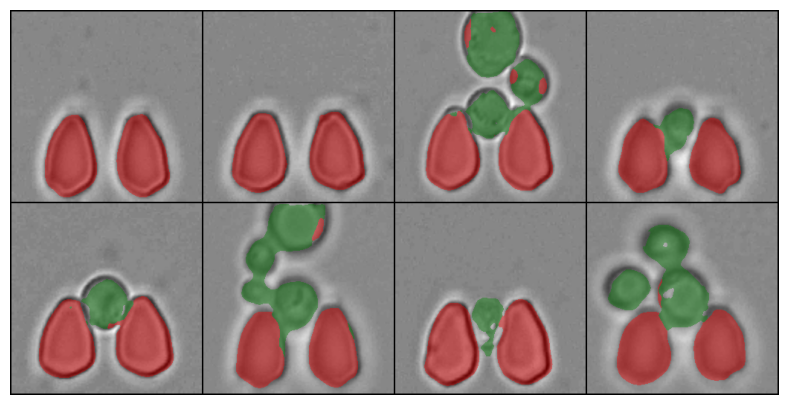

In [54]:
original_images_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
masks_grid = torchvision.utils.make_grid(
    torch.nn.functional.one_hot(predictions.argmax(dim=1), 3).permute(0, 3, 1, 2)[:, 1:]
    > 0,
    nrow=4,
)

predictions_grid = torchvision.utils.draw_segmentation_masks(
    original_images_grid,
    masks=masks_grid,
    alpha=0.4,
    colors=["red", "green"],
)

plt.figure(figsize=(12, 5))
plt.axis("off")
plt.imshow(transforms.ToPILImage()(predictions_grid))